### Figure S8 of *Grund & Ritter (2020)*, GJI

This Jupyter Notebook allows to reproduce **Fig. S8** (Supporting Information) of our GJI paper:

> _**Grund, M. & Ritter, J. R. R. (2020)**_, Shear-wave splitting beneath Fennoscandia — evidence for dipping structures and laterally varying multilayer anisotropy, *Geophysical Journal International*, https://doi.org/10.1093/gji/ggaa388.


Feel free to modify or play around with the different parameters!

**PyGMT and GMT requirements history:**
* 2025-08-20 (original version): PyGMT [0.16.0](https://www.pygmt.org/v0.16.0/index.html) & GMT >= [6.4.0](https://docs.generic-mapping-tools.org/6.4/)

**Additional required packages:**
* pandas
* numpy

**Author**: 
* Michael Grund ([@michaelgrund](https://github.com/michaelgrund))

In [9]:
import pygmt
import numpy as np
import pandas as pd
import io

# define parameters for plotting
pygmt.config(MAP_GRID_PEN_PRIMARY = '0.3p,dimgrey',
             MAP_ANNOT_OFFSET_PRIMARY = '5p',
             MAP_ANNOT_OFFSET_SECONDARY = '5p',
             MAP_ANNOT_OBLIQUE = '30',
             FONT_ANNOT_PRIMARY = '8p,Helvetica', 
             FONT_LABEL = '8p',
             MAP_FRAME_TYPE = 'fancy',
             MAP_FRAME_WIDTH = '2p',
             MAP_FRAME_PEN = '1.1p',
             MAP_TICK_LENGTH_PRIMARY = '5p',
             MAP_LABEL_OFFSET = '5.5p')

Create a new pygmt figure object.

In [10]:
fig = pygmt.Figure()

Next we define the map content and plot an elevation grid as background using the `grdimage` method.
* Here we can directly access the elevation grid via PyGMT by defining the desired resolution (`'@earth_relief_01m'`, corresponds to ETOPO1 data). Afterwards the required grid of the area is automatically extracted based on the defined region limits (`region = [3.5, 36.5, 54, 71.5]`). The first time you access an elevation grid file it will be downloaded from the GMT server and stored under your GMT user directory. Then the grid file is read from there. For further details see https://www.generic-mapping-tools.org/remote-datasets/.
* We use an Albers conic equal-area projection via `projection = 'l20/60/16/80/1:10000000'`.
* The background is colored by using the colormap `gray.cpt` and shading is set to `True`.

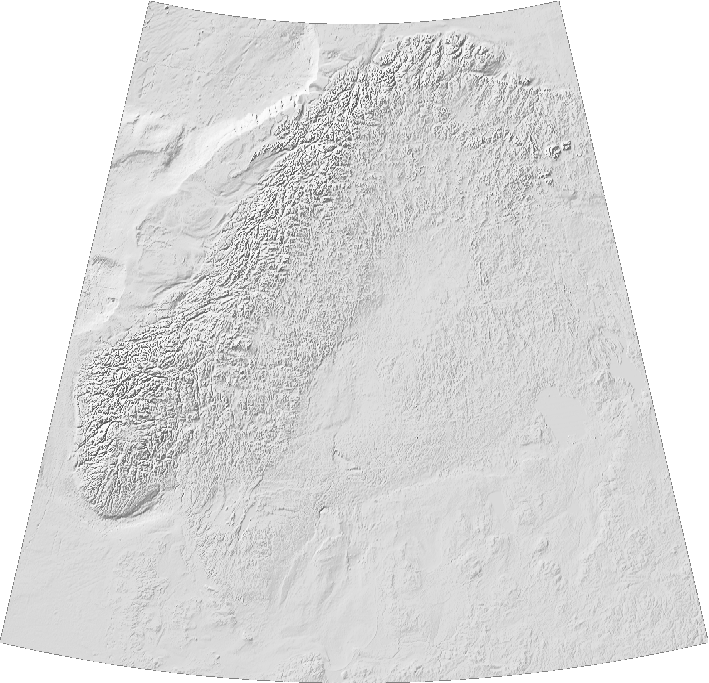

In [11]:
fig.grdimage('@earth_relief_01m',  
             region = [3.5, 36.5, 54, 71.5], 
             projection = 'l20/60/16/80/1:10000000',
             shading = True,
             cmap = 'gray.cpt')

# set the resolution of the figures that are displayed in the notebook below (reduces file size),
# in the end the figure is saved in png format in high resolution
dpifig = 100
fig.show(dpi = dpifig)

Now let's use the `coast` method to
* plot high resolution shorelines (`resolution = 'h'`) in black on top (`'1/0.5p,black'`)
* color oceans and water areas in white (`water = 'white'`)
* fill lakes in lightgray via `lakes = 'lightgray'` (so they are not clearly visible)
* add a fancy map frame with annotations every 5°'s in latitude and longitude direction and display these annotations on each axis (`frame = ['x5', 'y5', 'SNEW']`)
* add a map scale in the lower right corner

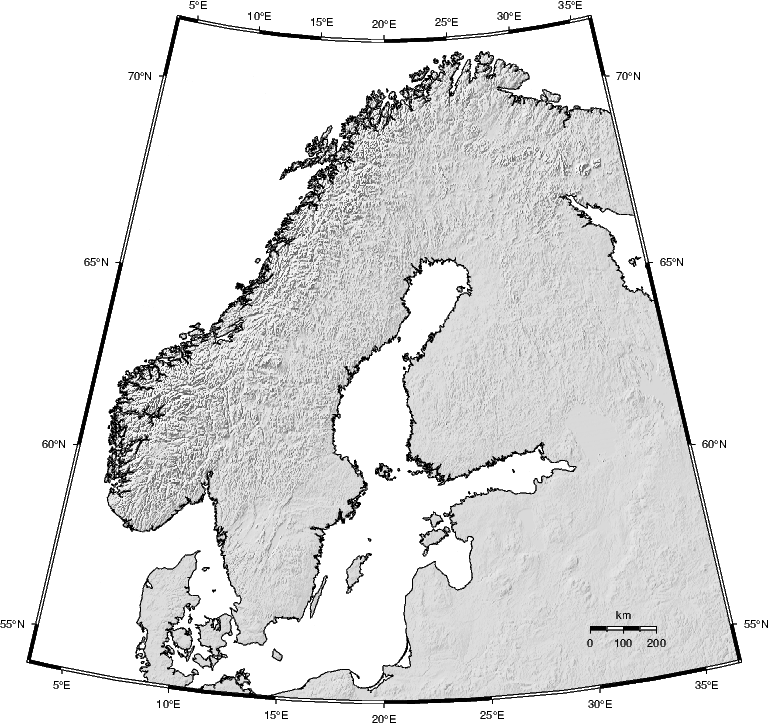

In [12]:
fig.coast(resolution = 'h', 
          shorelines = '1/thinnest,black', 
          water = 'white',
          lakes = 'lightgray', 
          frame = ['x5', 'y5', 'SNEW'],
          area_thresh = ['20/0/1'],
          map_scale = 'f31.5/55.5/56/200+lkm+jt')

fig.show(dpi = dpifig)

Now we add tectonic features like 
* shear zones
* inferred paleo-subduction zones 
* the digitized Tornquist zone

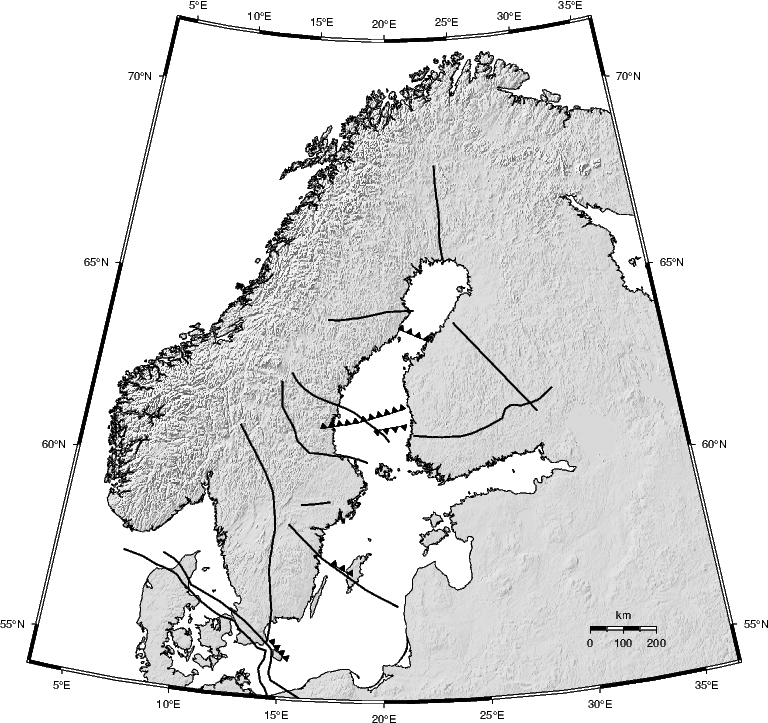

In [13]:
# read in file using pandas
filein2 = 'scan_shear_zones.dat'
namescol2 = ['lon', 'lat', 'name']
datatab2 = pd.read_table(filein2, sep=r"\s+", skiprows = 5, names = namescol2)

# get single names of individual structures to plot
names = list(set(datatab2['name']))
namescl = [x for x in names if str(x) != 'nan']

for name in namescl: # go through the different names 
    tabfilt21 = datatab2[(datatab2['name'] == name)].copy()
    
    tabfilt21['lon'] = tabfilt21['lon'].astype(float) # convert to float
    lons = tabfilt21['lon']
    lats = tabfilt21['lat']
    
    # first distinguish between shear zones and subduction zones
    if name.startswith('Shear'):
        fig.plot(x = lons, y = lats, pen = '1p,black')
    else:
        
        # now distinguish in which direction ((l)eft or (r)ight) sawtooth pattern should be plotted
        if name.endswith('r'):    
            fig.plot(x = lons, 
                     y = lats, 
                     style = 'f0.2/0.15+t+r', 
                     pen = 'thinnest,black',
                     fill = 'black')
        else:
            fig.plot(x = lons, 
                     y = lats, 
                     style = 'f0.2/0.15+t+l', 
                     pen = 'thinnest,black', 
                     fill = 'black')
                    
# Tornquist Zone, read in file using pandas, we can use the columnnames from above here 
filein3 = 'scan_STZ.dat'
datatab3 = pd.read_table(filein3, sep=r"\s+", skiprows = 3, names = namescol2)

# get single names of individual structures to plot
names2 = list(set(datatab3['name']))
namescl2 = [x for x in names2 if str(x) != 'nan']  
   
# plot the Tornquist zone 
for name in namescl2:   
    tabfilt31 = datatab3[(datatab3['name'] == name)].copy()
    
    tabfilt31['lon'] = tabfilt31['lon'].astype(float) # convert to float
    lons = tabfilt31['lon']
    lats = tabfilt31['lat']
    
    fig.plot(x = lons, y = lats, pen = '1p,black')            
              
fig.show(dpi = dpifig)

Before plotting, we define a function `proc_input_data()` for processing the input files which contain the splitting results of individual previous studies (see **References** at the bottom of this notebook). This function is used multiple times in the following.

**Please note**: below, the delay times of the input data are multiplied by a factor of **60**. However, this is only done for plotting reasons. 

In [14]:
# function to process input data files
def proc_input_data(file): 
    namescol = ['lon', 'lat', 'phi', 'dt', 'staname', 'phase']
    df = pd.read_csv(file, 
                     sep=r"\s+", 
                     header=None, 
                     names = namescol
                    )
    
    # rearrange column order
    cols = df.columns.tolist()
    cols = cols[0:3] + cols[4:4] + cols[3:4]
    df = df[cols]
    df.insert(4, "width", 8)
    df["dt"] = df["dt"] * 60

    return df    

Now we plot the splitting data of the studies via another defined function `plt_bars()`:

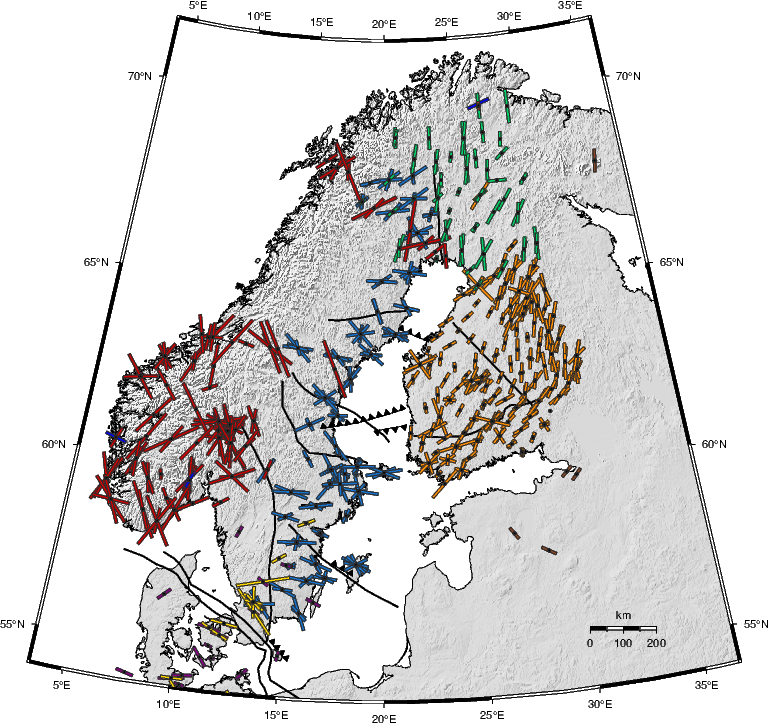

In [15]:
# function to plot splitting bars using rotated rectangles
def plt_bars(df, fillcol):
    bar_edgecol = '44/44/44'
    fig.plot(data = df,
             style = 'J', 
             pen ='0.25p,' + bar_edgecol, 
             fill = fillcol)
    
    # plot black dots atop the locations of stations
    fig.plot(x = df.lon, 
             y = df.lat,
             style = 'c0.08c', 
             pen ='0.5p,44/44/44', 
             fill = 'black')

# plot splitting bars for all previous studies
plt_bars(proc_input_data('splits_Vecsey_et_al_2007.geo'), 'darkorange')
plt_bars(proc_input_data('splits_Eken_et_al_2010.geo'), 'dodgerblue3')
plt_bars(proc_input_data('splits_Roy_Ritter_2013.geo'), 'red3')
plt_bars(proc_input_data('splits_Vinnik_et_al_2014.geo'), 'springgreen3')
plt_bars(proc_input_data('splits_Wylegalla_et_al_1999.geo'), 'magenta4')
plt_bars(proc_input_data('splits_Vinnik_et_al_1992.geo'), 'blue')
plt_bars(proc_input_data('splits_Plomerova_et_al_2002.geo'), 'gold')
plt_bars(proc_input_data('splits_Wuestefeld_et_al_2010.geo'), 'sienna4')

fig.show(dpi = dpifig)

Next we build a custom legend for the individual bars and add them in the upper left corner of the map:

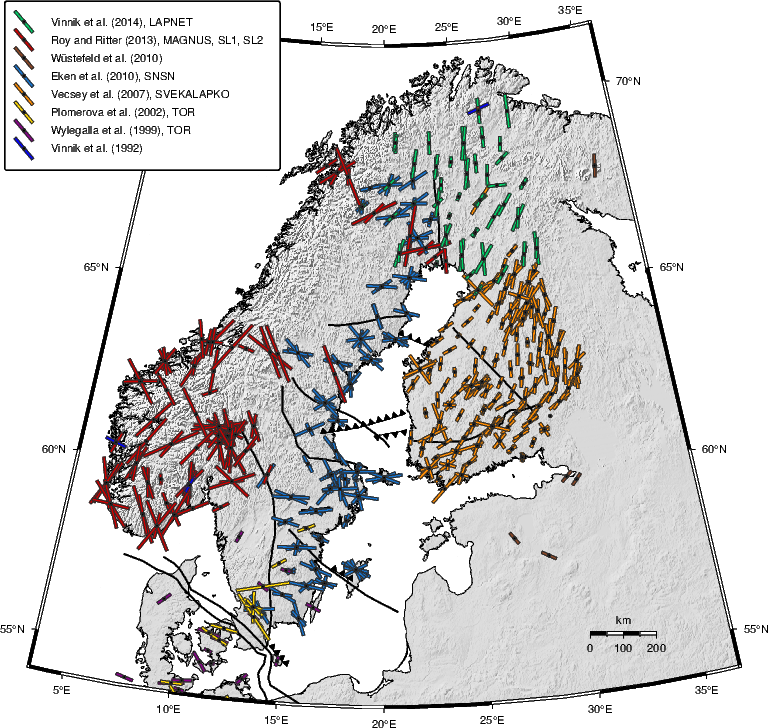

In [16]:
bar_edgecol = '44/44/44'    

# define legend content
spec_io = io.StringIO(
f"""
G 0.09i
N 3
S 0.35c j 40,2p,0.7c springgreen3 0.25p,{bar_edgecol} 
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Vinnik et al. (2014), LAPNET
G 0.15c
S 0.35c j 40,2p,0.7c red3 0.25p,{bar_edgecol} 
S -1.98c c 0.08c black 0.5p,44/44/44 -1.3c Roy and Ritter (2013), MAGNUS, SL1, SL2
G 0.15c
S 0.35c j 40,2p,0.7c sienna4 0.25p,{bar_edgecol} 
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c W@ustefeld et al. (2010)
G 0.15c
S 0.35c j 40,2p,0.7c dodgerblue3 0.25p,{bar_edgecol} 
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Eken et al. (2010), SNSN
G 0.15c
S 0.35c j 40,2p,0.7c darkorange 0.25p,{bar_edgecol}
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Vecsey et al. (2007), SVEKALAPKO
G 0.15c
S 0.35c j 40,2p,0.7c gold 0.25p,{bar_edgecol}
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Plomerova et al. (2002), TOR
G 0.15c
S 0.35c j 40,2p,0.7c magenta4 0.25p,{bar_edgecol}
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Wylegalla et al. (1999), TOR
G 0.15c
S 0.35c j 40,2p,0.7c blue 0.25p,{bar_edgecol}
S -1.98c c 0.08c black 0.5p,{bar_edgecol} -1.3c Vinnik et al. (1992)
G 0.15c
G 0.02i
"""
)
# generate legend    
fig.legend(spec=spec_io, position = 'x-0.65/13.6/7.0c/4.3c/BL', box='+pblack+r2p+gwhite+p0.8p')

fig.show(dpi = dpifig)

Another custom legend giving information regarding the bar lengths is added in the following:

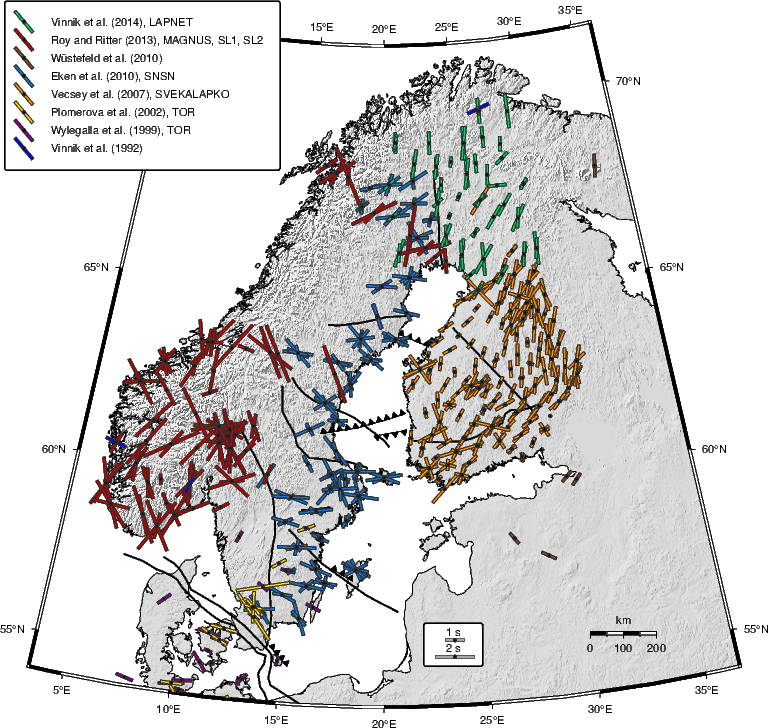

In [17]:
bar_fillcol = 'darkgray'

# define legend content
spec_io = io.StringIO(
f"""
G 0.09i
N 3
G -0.3c
H 8 Helvetica  1 s
G -0.1c
S 0.65c j 90,2.2p,0.5c {bar_fillcol} 0.25p,{bar_edgecol}
S 0.15c c 0.08c black 0.5p,{bar_edgecol} -1.3c
G -0.1c
H 8 Helvetica  2 s
G -0.1c
S 0.65c j 90,2.2p,1c {bar_fillcol} 0.25p,{bar_edgecol}
S 0.15c c 0.08c black 0.5p,{bar_edgecol} -1.3c
"""
)

# generate legend    
fig.legend(spec = spec_io, position = 'x10/1/1.5c/1.1c/BL', box = '+r2p+pblack+gwhite+p0.8p')

fig.show(dpi = dpifig)

Finally, we add single roseplots for the four largest studies (in their corresponding color) as well as for all displayed splitting bars (darkgray color fill):

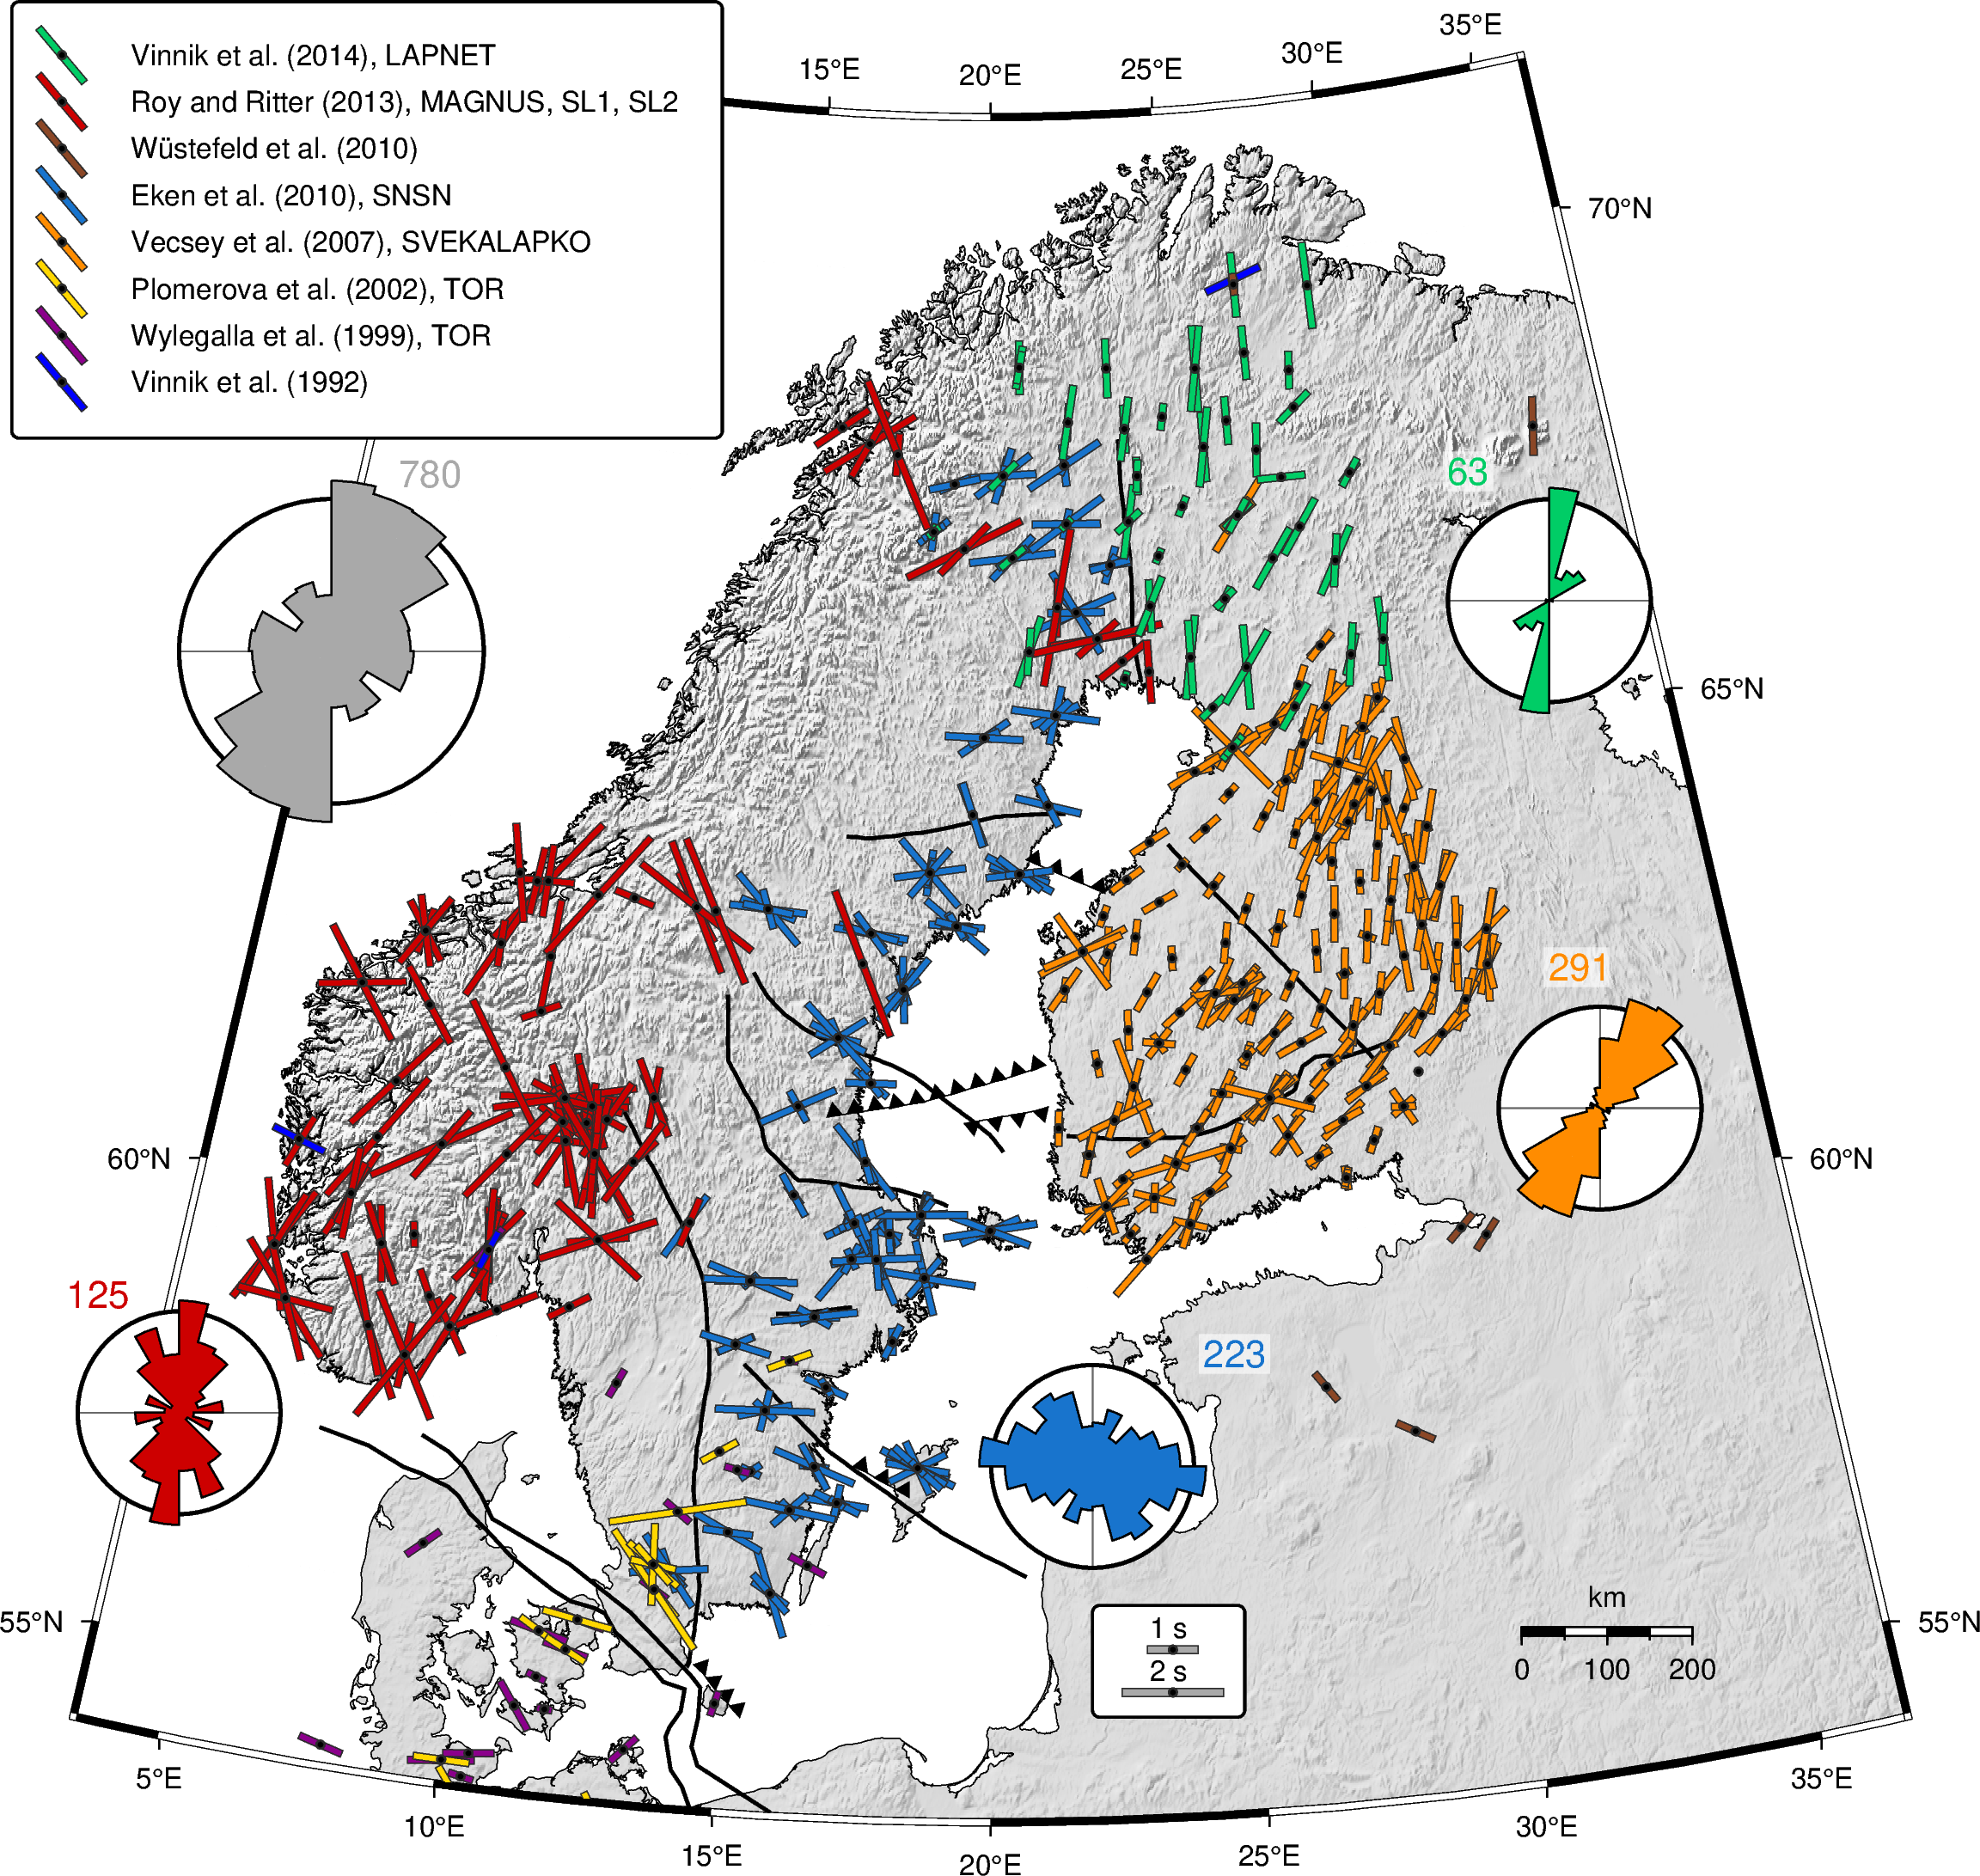

In [18]:
# function to plot splitting data summary in roseplot
def plt_rose(df, fillcol, scale, xshift, yshift, text_x, text_y, diameter = '2c'):
    
    with fig.shift_origin(xshift = xshift, yshift = yshift):
    
        with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '1.5p'):
            fig.rose(length = 0, # set dummy value 
                     azimuth = 0, # set dummy value 
                     region = [0, 1, 0, 360],
                     diameter = diameter,
                     frame = ['y90g90', '+gwhite'], # only show azimuthal grid in NESW dirs, no radial grid is plotted
                     labels = '-,-,-,-', # display no labels
                     pen = '0.75p,black'
            )
        
        fig.rose(length = df.width, # we just use this data here since it has the same length as the azimuths and constant values
                 azimuth = df.phi, # that's the important directional data 
                 region = [0, 1, 0, 360],
                 diameter = diameter,
                 sector = '15',
                 pen = '0.5p,black',
                 scale = scale, # scale the data radii down, this is done by trial and error until it fits
                 fill = fillcol,
                 orientation = True
        )
        
        fig.text(x = text_x,
                 y = text_y,
                 text = len(df),
                 font = '10.5p, Helvetica ' + fillcol,
                 fill = 'white@40',
                 #transparency = 40,
                 no_clip = True
                )

# add single roseplots for four largest studies
plt_rose(df = proc_input_data('splits_Vecsey_et_al_2007.geo'), fillcol = 'darkorange', 
         scale = 0.0021, xshift = 14, yshift = 6, text_x = 0.4, text_y = 430)
plt_rose(df = proc_input_data('splits_Eken_et_al_2010.geo'), fillcol = 'dodgerblue3', 
         scale = 0.0045, xshift = 9, yshift = 2.47, text_x = 1.2, text_y = 380)
plt_rose(df = proc_input_data('splits_Roy_Ritter_2013.geo'), fillcol = 'red3', 
         scale = 0.006, xshift = 0, yshift = 3, text_x = 0.1, text_y = 390)
plt_rose(df = proc_input_data('splits_Vinnik_et_al_2014.geo'), fillcol = 'springgreen3', 
         scale = 0.0042, xshift = 13.5, yshift = 11, text_x = 0.1, text_y = 410)

# add summary roseplot for all studies in darkgray
dfs = [proc_input_data('splits_Vecsey_et_al_2007.geo'),
          proc_input_data('splits_Eken_et_al_2010.geo'),
          proc_input_data('splits_Roy_Ritter_2013.geo'),
          proc_input_data('splits_Vinnik_et_al_2014.geo'),
          proc_input_data('splits_Wylegalla_et_al_1999.geo'),
          proc_input_data('splits_Vinnik_et_al_1992.geo'),
          proc_input_data('splits_Plomerova_et_al_2002.geo'), 
          proc_input_data('splits_Wuestefeld_et_al_2010.geo')
         ]

df_merged = pd.concat(dfs, ignore_index=False)

plt_rose(df = df_merged, fillcol = 'darkgray', 
         scale = 0.00125, xshift = 1, yshift = 10, text_x = 0.825, text_y = 390, 
         diameter = '3c')

# finally show in full resolution
fig.show()

Save the figure in png format:

In [19]:
fig.savefig('PLOT_figs8.png', dpi = 300)

### References

* **Vinnik et al. (1992)**, *Geophys. J. Int.* 111, Global patterns of azimuthal anisotropy and deformations in the continental mantle, https://doi.org/10.1111/j.1365-246X.1992.tb02102.x

* **Wylegalla et al. (1999)**, *Tectonophysics* 314, Anisotropy across the Sorgenfrei-Tornquist Zone from shear wave splitting, https://doi.org/10.1016/S0040-1951(99)00252-8

* **Plomerova et al. (2002)**, *Tectonophysics* 360, Seismic anisotropy of the lithosphere around the Trans-European Suture Zone (TESZ) based on teleseismic body-wave data of the TOR experiment, 10.1016/s0040-1951(02)00349-9 

* **Vecsey et al. (2007)**, *Tectonophysics* 438, Shear wave splitting as a diagnostic of variable anisotropic structure of the upper mantle beneath central Fennoscandia, https://doi.org/10.1016/j.tecto.2007.02.017

* **Eken et al. (2010)**, *Tectonophysics* 480, Seismic anisotropy of the mantle lithosphere beneath the Swedish National Seismological Network (SNSN), https://doi.org/10.1016/j.tecto.2009.10.012

* **Wüstefeld et al. (2010)**, *Tectonophysics* 481, Evidence for ancient lithospheric deformation in the East European Craton based on mantle seismic anisotropy and crustal magnetics, https://doi.org/10.1016/j.tecto.2009.01.010

* **Roy & Ritter (2013)**, *J. Seism.* 17, Complex deep seismic anisotropy below the Scandinavian Mountains, https://doi.org/10.1007/s10950-012-9325-4

* **Vinnik et al. (2014)**, *Tectonophysics* 628, Anisotropic lithosphere under the Fennoscandian shield from P receiver functions and SKS waveforms of the POLENET/LAPNET array, https://doi.org/10.1016/j.tecto.2014.04.024